In [1]:
import cv2
import torch
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from kornia.filters import gaussian_blur2d

In [2]:
import sys
sys.path.append('kair_models')
from kair_models import network_dncnn
dncnn = network_dncnn.DnCNN(in_nc=3, out_nc=3, nc=64, nb=20, act_mode='R')
dncnn.load_state_dict(torch.load('./dncnn_color_blind.pth'), strict=True)
dncnn.eval()
for k, v in dncnn.named_parameters():
    v.requires_grad = False
dncnn = dncnn.cuda()

In [3]:
def cnn_denoise(model, im):
    im_th_cu = torch.from_numpy(im.transpose((2, 0, 1))).unsqueeze(0).cuda()
    denoised_im_th_cu = model(im_th_cu)
    denoised_im = denoised_im_th_cu.squeeze(0).cpu().numpy().transpose((1, 2, 0))
    return denoised_im

In [4]:
im = cv2.imread('/mnt/kangfu/Experiments/datasets/Set9/image_Peppers512rgb.png')[:,:,::-1]
im = im.astype(np.float32) / 255.

noisy_im = cv2.imread('/home/kangfu.mkf/Codes/film_grain_rendering_gpu/Set4/image_Peppers512rgb.png')[:,:,::-1]
noisy_im = noisy_im.astype(np.float32) / 255.

In [5]:
pre_denoised_im = cnn_denoise(dncnn, noisy_im)

kernel_size = 3
low_freq_im = cv2.GaussianBlur(pre_denoised_im, (kernel_size, kernel_size), 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


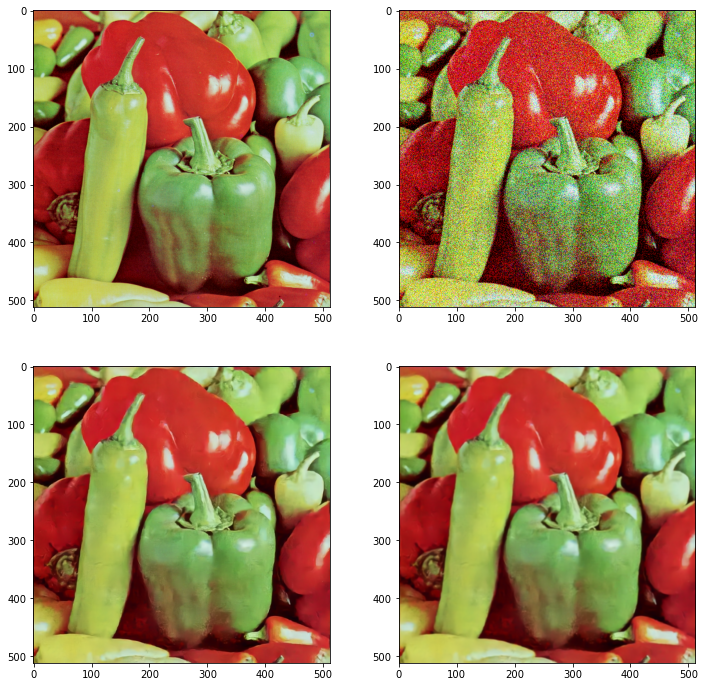

In [6]:
plt.figure(figsize=(12, 12))

plt.subplot(221)
plt.imshow(im)

plt.subplot(222)
plt.imshow(noisy_im)

plt.subplot(223)
plt.imshow(pre_denoised_im)

plt.subplot(224)
plt.imshow(low_freq_im)

In [7]:
20 * np.log10(1 / np.sqrt(np.mean((pre_denoised_im - im)**2)))

28.06739172301361

In [8]:
20 * np.log10(1 / np.sqrt(np.mean((noisy_im - im)**2)))

13.989406115195315

In [9]:
# low_psnr_vs_sigma = []
# for kernel_size in [5, 7, 9, 11, 21, 31]:
#     psnr_vs_sigma = []
#     for sigma in [25,50,75,100]:
#         noise = np.random.normal(scale=sigma / 255., size=im.shape).astype(np.float32)
#         noisy_im = np.clip((im + noise).astype(np.float32), 0., 1.)
#         pre_denoised_im = cnn_denoise(dncnn, noisy_im)

#         low_freq_im = cv2.GaussianBlur(im, (kernel_size, kernel_size), 0)
#         low_freq_denoise_im = cv2.GaussianBlur(pre_denoised_im, (kernel_size, kernel_size), 0)

#         psnr_vs_sigma.append(20 * np.log10(1 / np.sqrt(np.mean((low_freq_denoise_im - low_freq_im)**2))))
#     low_psnr_vs_sigma.append(psnr_vs_sigma)
# for i, l in zip([5, 7, 9, 11, 21, 31], low_psnr_vs_sigma):
#     plt.plot([25,50,75,100], l, label=i)
# plt.legend()
# plt.grid()

In [10]:
import torch
from torchvision.transforms.functional import normalize

im_th = normalize(torch.from_numpy((im.transpose((2, 0, 1)))), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)).unsqueeze(0).cuda()
noisy_im_th = normalize(torch.from_numpy((noisy_im.transpose((2, 0, 1)))), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)).unsqueeze(0).cuda()
im_low_freq_th = normalize(torch.from_numpy((low_freq_im.transpose((2, 0, 1)))), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)).unsqueeze(0).cuda()

In [11]:
from models import InverseVAENetwork

import yaml
with open('./tb_logs/guassian_prediction_low_content/version_4/hparams.yaml') as file:
    hparams = yaml.load(file, Loader=yaml.FullLoader)  
hparams['ganFeat_loss'] = True
hparams

{'aspect_ratio': 1.0,
 'batch_size': 8,
 'checkpoint': '/mnt/kangfu/Experiments/checkpoints',
 'crop_size': 512,
 'dataset': 'GaussianDataset',
 'decay_epoch': 200,
 'enorm': 'batch',
 'ganFeat_loss': True,
 'gan_mode': 'hinge',
 'gaussian_size': 21,
 'gnorm': 'batch',
 'gpus': -1,
 'lambda_content': 1.0,
 'lambda_feat': 10.0,
 'lambda_gan': 2.0,
 'lambda_rkld': 2.0,
 'lambda_vgg': 10.0,
 'learning_rate': 1e-05,
 'low_loss': True,
 'model': 'InverseVAENetwork',
 'n_layers_D': 4,
 'name': 'guassian_prediction_low_content',
 'ndf': 64,
 'nef': 128,
 'ngf': 128,
 'nodes': 1,
 'num_D': 3,
 'output_root': '',
 'resume': None,
 'rkld_loss': True,
 'sync_bn': True,
 'test': False,
 'threads': 8,
 'train_data_root': '/mnt/kangfu/Experiments/datasets/DIV2K_Flickr2K/',
 'use_amp': False,
 'val': 1,
 'val_data_root': '/mnt/kangfu/Experiments/datasets/Set4/',
 'vgg_loss': True,
 'workers': 8}

In [12]:
pipa = InverseVAENetwork(hparams)
checkpoint = torch.load('/mnt/kangfu/Experiments/checkpoints/guassian_prediction_low_contentepoch=799.ckpt', map_location=lambda storage, loc: storage)
pipa.load_state_dict(checkpoint['state_dict'])
pipa = pipa.cuda()
pipa = pipa.eval()

In [65]:
with torch.no_grad():
    zs = pipa.encoder(im_low_freq_th)
    noisy_zs = []
    noises = []
    for z in zs:
        noise = torch.randn(z.size(), device=z.device)
        noisy_zs.append(z + noise) 
        noises.append(noise)
    output = pipa.generator(noisy_zs)

output_np = ((output + 1) / 2).squeeze(0).detach().cpu().numpy().transpose((1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'First')

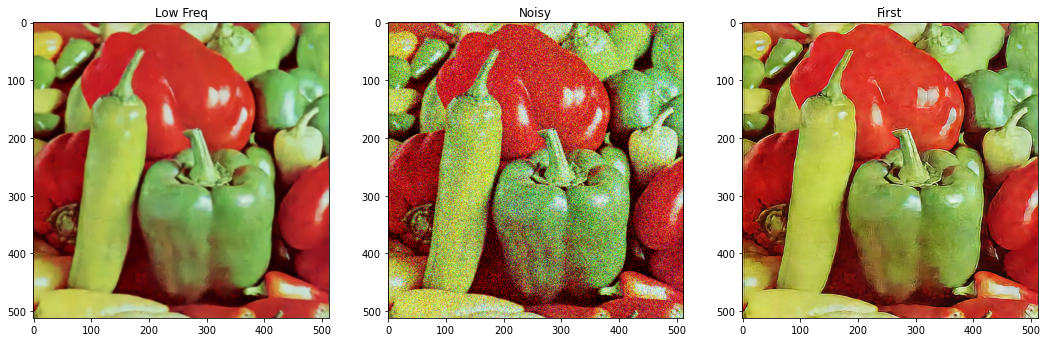

In [66]:
plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.imshow(low_freq_im)
plt.title("Low Freq")

plt.subplot(132)
plt.imshow(noisy_im)
plt.title("Noisy")


plt.subplot(133)
plt.imshow(output_np)
plt.title("First")

In [67]:
20 * np.log10(1 / np.sqrt(np.mean((output_np - im)**2)))

21.98638468624262

In [68]:
for i in range(len(noises)):
    noises[i].requires_grad=True
optimizer = torch.optim.Adam(noises, lr=0.01, betas=(0., 0.999), weight_decay=0, eps=1e-8)

In [69]:
def gan_feat_loss(pipa, output, label):
    pred_fake, pred_real = pipa.discriminate(output, label)
    GAN_Feat_loss = torch.tensor([0.], device=output.device)
    num_D = len(pred_fake)    
    for i in range(num_D):
        num_intermediate_outputs = len(pred_fake[i]) - 1
        for j in range(num_intermediate_outputs):
            unweighted_loss = torch.nn.functional.l1_loss(pred_fake[i][j], pred_real[i][j].detach())
            GAN_Feat_loss += unweighted_loss / num_D
    
    return GAN_Feat_loss

In [ ]:
history = []
psnrs = []
kls = []


kl_weight = 1000
for i in range(10000):
    optimizer.zero_grad()
    loss = 0
    
    noisy_zs = []
    for z,noise in zip(zs, noises):
        noisy_zs.append(z + noise) 
    output = pipa.generator(noisy_zs)
    
#     gan_loss = gan_feat_loss(pipa, output, noisy_im_th)[0]*0.1

    
#     blur_output = gaussian_blur2d(output, (11, 11), (10, 10))
#     blur_im = gaussian_blur2d(noisy_im_th, (11, 11), (10, 10))
#     content_loss = torch.nn.functional.mse_loss(blur_output, blur_im) * 2
    content_loss = torch.nn.functional.mse_loss(output, noisy_im_th)

    kl = 0
    for noise in noises:
        kl += torch.mean(noise)**2
    
    
#     gan_loss = -torch.mean(pipa.discriminator(output)[-1][-1]) * 0.01
    output = ((output+1)/2).squeeze(0).detach().cpu().numpy().transpose((1, 2, 0))
    
    psnr = 20 * np.log10(1 / np.sqrt(np.mean((output - im)**2)))
    
    loss += content_loss
    loss += kl * kl_weight
#     loss += gan_loss
    
    loss.backward()
    optimizer.step()
    print("\r Step: ", i,
          " KL: ", kl.item(),
#           " GAN: ", gan_loss.item(),
          " Content: ", content_loss.item(),
          " PSNR: ", psnr,
          " Loss: ", loss.item(), end="")
    output_im = np.clip(np.uint8(output * 255.), 0, 255)
    history.append(output_im)
    psnrs.append(psnr)
    kls.append(kl)
    if i> 0 and i % 4000 == 0:
        kl_weight *= 10
        print("KL from", kl_weight * 0.1, "into", kl_weight)

 Step:  3683  KL:  0.00013974792091175914  Content:  0.12706351280212402  PSNR:  21.506786778140206  Loss:  0.26681143045425415

In [ ]:
plt.figure(figsize=(12, 12))

plt.subplot(221)
plt.imshow(noisy_im)
plt.title('Noisy Image')

plt.subplot(222)
plt.imshow(low_freq_im)
plt.title('Low Frequency Output')

plt.subplot(223)
plt.imshow(history[0])
plt.title('First-Stage Output')

plt.subplot(224)
plt.imshow(history[-1])
plt.title('Optimized Output')

# plt.savefig('./output.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'KLD Restraint')

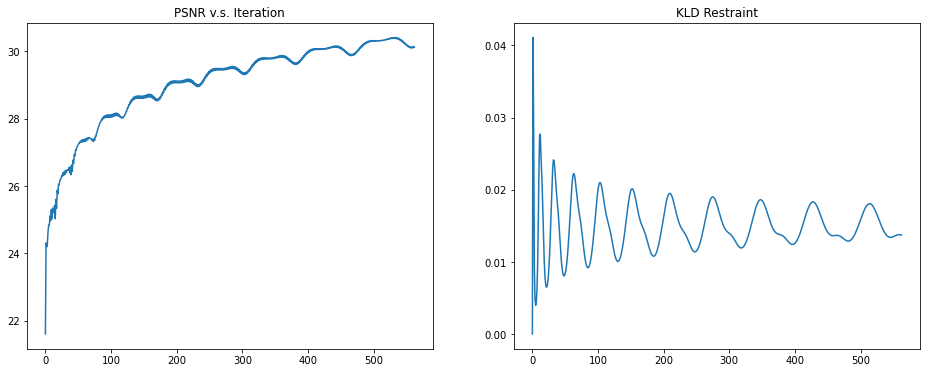

In [56]:
plt.figure(figsize=(16, 6))

plt.subplot(121)
plt.plot(psnrs)
plt.title('PSNR v.s. Iteration')

plt.subplot(122)
plt.plot(kls)
plt.title('KLD Restraint')

# plt.savefig('./loss.png', dpi=300, bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Optimized Result')

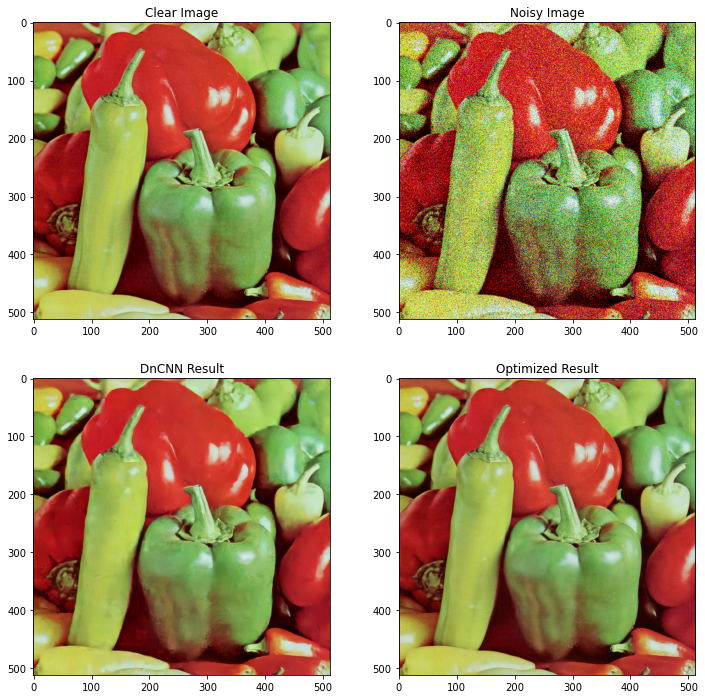

In [57]:
plt.figure(figsize=(12, 12))

plt.subplot(221)
plt.imshow(im)
plt.title("Clear Image")

plt.subplot(222)
plt.imshow(noisy_im)
plt.title("Noisy Image")

plt.subplot(223)
plt.imshow(pre_denoised_im)
plt.title("DnCNN Result")

plt.subplot(224)
plt.imshow(history[-1])
plt.title("Optimized Result")

# plt.savefig("result1.png", dpi=300)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


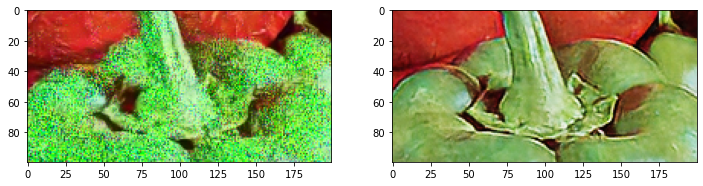

In [32]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(pre_denoised_im[200:300, 200:400])

plt.subplot(122)
plt.imshow(history[-1][200:300, 200:400])